In [1]:
import os
import shutil
import urllib3
from subprocess import Popen, PIPE, STDOUT
from multiprocessing import Pool

import numpy as np
from matplotlib import pyplot as plt

### 0. Класс с параметрами атома

In [2]:
class Atom:
    def __init__(self, z, lattice_a, pseudo, atomic_mass):
        self.pseudo = pseudo
        self.celldim = Atom._celldim(lattice_a)
        self.z = z
        self.atomic_mass = atomic_mass
        
    def __str__(self):
        return f'Z={self.z}, celldim={self.celldim}, m={self.atomic_mass}, pseudo={self.pseudo}'
        
    def get_pseudo_file(self):
        return self.pseudo
    
    def get_celldim(self):
        return self.celldim
    
    def get_atomic_mass(self):
        return self.atomic_mass
    
    @staticmethod
    def _celldim(x, a=52.9177):
        # a - радиус Бора в пикометрах
        return x / a

In [3]:
def parse_output(output):
    pattern = ['!', 'total', 'energy']
    
    for line in output.splitlines():
        items = line.split()
        if items[:3] == pattern:
            return float(items[4])

### 1. Конфигурация

In [4]:
pseudo_url2atom = {
    'C': 'https://www.quantum-espresso.org/upf_files/C.pbe-n-kjpaw_psl.1.0.0.UPF',
    'Si': 'https://www.quantum-espresso.org/upf_files/Si.pbe-n-kjpaw_psl.1.0.0.UPF',
    'Ge': 'https://www.quantum-espresso.org/upf_files/Ge.pbe-dn-kjpaw_psl.1.0.0.UPF',
    'Sn': 'https://www.quantum-espresso.org/upf_files/Sn.pbe-dn-kjpaw_psl.1.0.0.UPF'
}
pseudo_dir = 'data/pseudo/pbe'
output_dir = 'output'

# "а" параметр решетки в пикометрах
# Взял тут https://www.webelements.com/tin/crystal_structure.html
lattice_a2atom = {
    'C':  246.4,
    'Si': 543.09,
    'Ge': 565.75,
    'Sn': 583.18,
}

# Атомный номер
z2atom = {
    'C':  6,
    'Si': 14,
    'Ge': 32,
    'Sn': 50
}

atomic_mass = {
    'C':  12.011,
    'Si': 28.085,
    'Ge': 72.630,
    'Sn': 118.710
}

In [5]:
os.makedirs(pseudo_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

In [6]:
http = urllib3.PoolManager()
atoms = {}

for atom_key, url_str in pseudo_url2atom.items():
    url = urllib3.util.parse_url(url_str)
    fname = url.path.split('/')[2]
    path = os.path.join(pseudo_dir, fname)
    
    if not os.path.exists(path): 
        with http.request('GET', url_str, preload_content=False) as r, open(path, 'wb') as f:       
            shutil.copyfileobj(r, f)
        
    atoms[atom_key] = Atom(z=z2atom[atom_key],
                           pseudo=fname,
                           lattice_a=lattice_a2atom[atom_key],
                           atomic_mass=atomic_mass[atom_key])

In [7]:
pwx_lattice_config = """&control
    prefix = '{0}',
    pseudo_dir = '{1}',
    outdir = '{2}',
/
&system
! better lattice parametrization
    ibrav = 2,
    celldm(1) = {3},
    ntyp = 1,
    nat = 2,
    ecutwfc = {4},
    ecutrho = {5},
/
&electrons
/
ATOMIC_SPECIES
    X {6} {7}
ATOMIC_POSITIONS alat
    X 0.00 0.00 0.00
    X 0.25 0.25 0.25
K_POINTS automatic
    6 6 6 1 1 1
"""

In [8]:
pwx_vacuum_config = """&control
    prefix = '{0}',
    pseudo_dir = '{1}',
    outdir = '{2}',
/
&system
    ibrav = 1,
    celldm(1) = {3},
    ntyp = 1,
    nat = 1,
    ecutwfc = {4},
    ecutrho = {5},
! magnetic calcualtions
    nspin = 2,
    starting_magnetization(1) = 1,
    occupations = 'smearing',
    degauss = 0.01,
/
&electrons
/
ATOMIC_SPECIES
    X {6} {7}
ATOMIC_POSITIONS alat
    X 0.00 0.00 0.00
K_POINTS gamma
! special calculation type for isolated atoms"""

In [9]:
N = 500
delta = 1e-2
pwx_exe='pw.x'
ecutwfc = 47
ecutrho = 250

### 2. Расчет полной энергии системы

In [10]:
atom = atoms['Ge']
print(atom)

Z=32, celldim=10.691129811008414, m=72.63, pseudo=Ge.pbe-dn-kjpaw_psl.1.0.0.UPF


In [11]:
dx = N * delta
celldims = np.arange(atom.get_celldim() - dx, atom.get_celldim() + dx, delta)

In [12]:
def calc_total_energy(celldim):
    conf = pwx_lattice_config.format(f'lattice_{celldim}',
                                    pseudo_dir,
                                    output_dir,
                                    celldim,
                                    ecutwfc,
                                    ecutrho,
                                    atom.get_atomic_mass(),
                                    atom.get_pseudo_file())
    p = Popen([pwx_exe], stdout=PIPE, stdin=PIPE, stderr=STDOUT)
    stdout, _ = p.communicate(input=conf.encode())
    output = stdout.decode()
    return parse_output(output)

In [13]:
with Pool(processes=12) as pool:
        total_energy = pool.map(calc_total_energy, celldims)

In [14]:
# Расчеты для некоторых значений параметров могли не сойтись
idx = [i for i, e in enumerate(total_energy) if e is None]
total_energy = list(filter(lambda e: e is not None, total_energy))
celldims = np.delete(celldims, idx)

In [15]:
np.save(os.path.join(output_dir, 'energy.npy'), np.array([celldims, total_energy]))

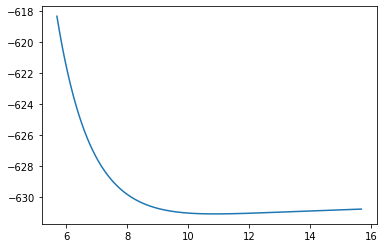

In [16]:
plt.plot(celldims, total_energy)

In [17]:
idx = np.argmin(total_energy)
min_celldim, min_energy = celldims[idx], total_energy[idx]
min_celldim, min_energy

(10.881129811008304, -631.07853836)

### 3. Поиск оптимальных параметров отсечения кинетической энергии для волновых функций, плотности заряда и потенциала

In [18]:
ecutwfc_values = [20, 30, 40, 50]
ecutrho_coeff = [3, 4, 5]

ecut_values = [(i, c * i) for i in ecutwfc_values for c in ecutrho_coeff]

In [19]:
def calc_energy_with_cutoff(values):
    ecutwfc, ecutrho = values
    conf = pwx_lattice_config.format(f'lattice_{ecutwfc}_{ecutrho}',
                                    pseudo_dir,
                                    output_dir,
                                    min_celldim,
                                    ecutwfc,
                                    ecutrho,
                                    atom.get_atomic_mass(),
                                    atom.get_pseudo_file())
    p = Popen([pwx_exe], stdout=PIPE, stdin=PIPE, stderr=STDOUT)
    stdout, _ = p.communicate(input=conf.encode())
    output = stdout.decode()
    output = parse_output(output)
    return ecutwfc, ecutrho, output if output is not None else None

In [20]:
with Pool(processes=12) as pool:
        results = pool.map(calc_energy_with_cutoff, ecut_values)

In [21]:
# Расчеты для некоторых значений параметров могли не сойтись
results = list(filter(lambda r: r is not None, results))

In [22]:
img_arr = [t[2] for t in results]
img = np.array(img_arr).reshape((len(ecutwfc_values), len(ecutrho_coeff)))
img, results

(array([[-626.48687542, -626.44483007, -626.43914203],
        [-630.93567973, -630.93580955, -630.9350146 ],
        [-631.07788382, -631.07700459, -631.07698086],
        [-631.08058808, -631.08058941, -631.08057565]]),
 [(20, 60, -626.48687542),
  (20, 80, -626.44483007),
  (20, 100, -626.43914203),
  (30, 90, -630.93567973),
  (30, 120, -630.93580955),
  (30, 150, -630.9350146),
  (40, 120, -631.07788382),
  (40, 160, -631.07700459),
  (40, 200, -631.07698086),
  (50, 150, -631.08058808),
  (50, 200, -631.08058941),
  (50, 250, -631.08057565)])

[[0.99272088 0.99265425 0.99264524]
 [0.99977038 0.99977058 0.99976932]
 [0.99999571 0.99999432 0.99999428]
 [1.         1.         0.99999998]]


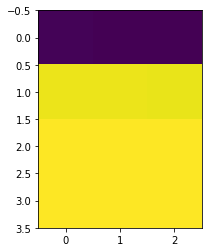

In [23]:
img = np.abs(img)
img /= np.max(img)
plt.imshow(img)
print(img)

### 4. Рассчет энергии когезии

In [24]:
def calc_vacuum_energy(celldim):
    conf = pwx_vacuum_config .format(f'vacuum_{celldim}',
                                    pseudo_dir,
                                    output_dir,
                                    2.5 * celldim,
                                    ecutwfc,
                                    ecutrho,
                                    atom.get_atomic_mass(),
                                    atom.get_pseudo_file())
    p = Popen([pwx_exe], stdout=PIPE, stdin=PIPE, stderr=STDOUT)
    stdout, _ = p.communicate(input=conf.encode())
    output = stdout.decode()
    return parse_output(output)

def cohesive_energy(e_lattice, e_vacuum):
    k = 13.6056980659 # eV / Ry
    return k * (e_lattice - e_vacuum)

In [25]:
vacuum_energy = calc_vacuum_energy(min_celldim)

In [26]:
cohesive_energy(min_energy / 2, vacuum_energy)

-3.656598295245002